# MLP - Multilayer Perceptron 

Iremos usar diferentes arquiteturas de MLP para comparar os resultados com dados vindo do FASHION MNIST. Nos testes, usarei o FASHION MNIST normal (com as imagens com 28px de dimensão), uma versão com as imagens transladadas aleatoriamente numa dimensão de 84 $\times$ 84 pixels e por fim as imagens na dimensão original, mas centralizadas numa dimensão de 84 $\times$ 84. 

In [31]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader

## Preparo dos Dados:

Nossa ideia vai ser produzir 3 datasets diferentes:
- Dataset A - Fashion MNIST normal;
- Dataset B - Imagens do Fashion MNIST transladas em uma malha de 84 x 84 pixels aleatoriamente a cada chamada;
- Dataset C - Imagens do Fashion MNIST transladas em uma malha de 84 x 84 pixel de forma fixa;

In [32]:
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, borda=28, transformar=True, transladar_fixo=True):
        self.data = pd.read_csv(csv_file)
        self.imagens = self.data.drop(columns=['label']).values / 255.0
        self.rotulos = self.data['label'].values
        self.borda = borda
        self.transformar = transformar  
        self.transladar_fixo = transladar_fixo

        if self.transformar & self.transladar_fixo:
            self.imagens = [self.transform_imagens(torch.tensor(imagem, dtype=torch.float).view(1, 28, 28)) for imagem in self.imagens]

    def __len__(self):
        return len(self.rotulos)

    def transform_imagens(self, X):
        novoX = torch.zeros(1, 28 + 2 * self.borda, 28 + 2 * self.borda)
        inicio_h = random.randint(0, 2 * self.borda)
        inicio_v = random.randint(0, 2 * self.borda)
        novoX[0, inicio_h:(inicio_h + 28), inicio_v:(inicio_v + 28)] = X.view(28, 28)
        return novoX

    def __getitem__(self, idx):
        if self.transladar_fixo:
            return self.imagens[idx], torch.tensor(self.rotulos[idx], dtype=torch.long)
        else:
            imagem = torch.tensor(self.imagens[idx], dtype=torch.float).view(1, 28, 28)
            rotulo = torch.tensor(self.rotulos[idx], dtype=torch.long)
            
            if self.transformar:
                imagem = self.transform_imagens(imagem)

            return imagem, rotulo
    
path_treino = 'datasets/fashion-mnist_train.csv'
path_teste = 'datasets/fashion-mnist_test.csv'

#### Dataset A - Fashion MNIST Normal

In [33]:
dataset_aux = FashionMNISTDataset(path_treino, borda=0, transformar=False, transladar_fixo=False)
treino_loader_A = DataLoader(dataset_aux, batch_size=64, shuffle=False)

In [34]:
dataset_aux = FashionMNISTDataset(path_teste, borda=0, transformar=False, transladar_fixo=False)
teste_loader_A = DataLoader(dataset_aux, batch_size=64, shuffle=False)


#### Dataset B - Fashion MNIST Transladado Fixamente 

In [35]:
dataset_aux = FashionMNISTDataset(path_treino, borda=14, transformar=True, transladar_fixo=True)
treino_loader_B = DataLoader(dataset_aux, batch_size=64, shuffle=False)

In [36]:
dataset_aux = FashionMNISTDataset(path_teste, borda=14, transformar=True, transladar_fixo=True)
teste_loader_B = DataLoader(dataset_aux, batch_size=64, shuffle=False)

#### Dataset C - Fashion MNIST Transladado Aleatoriamente

In [37]:
dataset_aux = FashionMNISTDataset(path_treino, borda=14, transformar=True, transladar_fixo=False)
treino_loader_C = DataLoader(dataset_aux, batch_size=64, shuffle=False)

In [38]:
dataset_aux = FashionMNISTDataset(path_teste, borda=14, transformar=True, transladar_fixo=False)
teste_loader_C = DataLoader(dataset_aux, batch_size=64, shuffle=False)

#### Verificando os Datasets:

Para verificar os datasets, coloquei o parâmetro `shuffle` do **DataLoader** como *false* para verificar as variações. 

In [39]:
def plot_imagens(imagens, num_colunas=5, scale=0.5):
    num_imagens = len(imagens)
    num_linhas = (num_imagens + num_colunas - 1) // num_colunas

    fig, axes = plt.subplots(num_linhas, num_colunas, figsize=(num_colunas * scale, num_linhas * scale))
    axes = axes.flatten()

    for i, (img, ax) in enumerate(zip(imagens, axes)):
        ax.imshow(img.numpy().squeeze(), cmap='inferno')
        ax.axis('off')  # Remove os eixos para uma visualização mais limpa

    for ax in axes[num_imagens:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def plot_10_imagens(loader):
    for imagens, _ in loader:
        plot_imagens(imagens[:10], num_colunas=5, scale=1.5)
        break

 >>> Dataset A


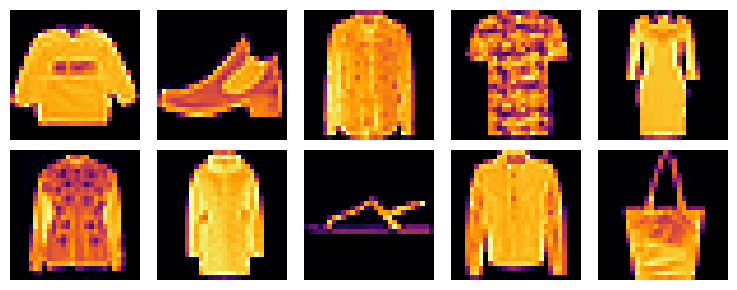

 >>> Dataset B


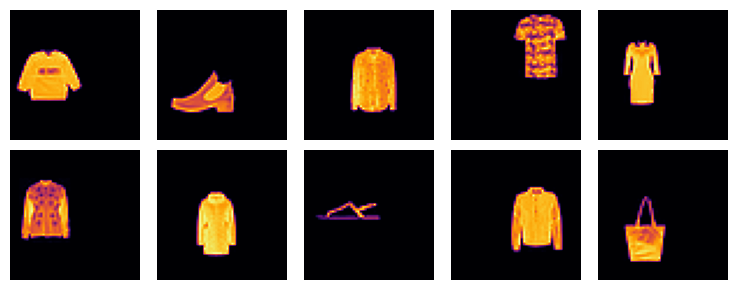

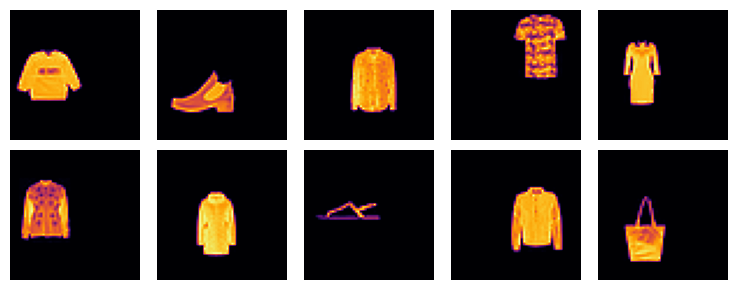

 >>> Dataset C


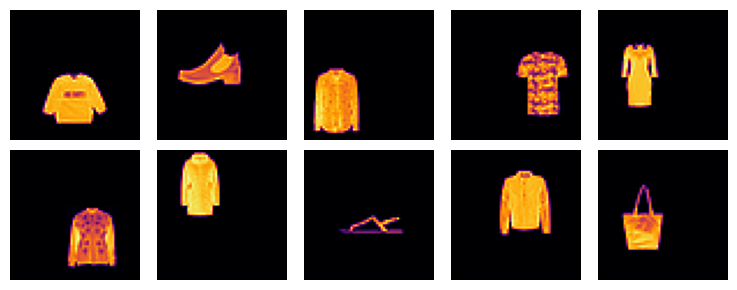

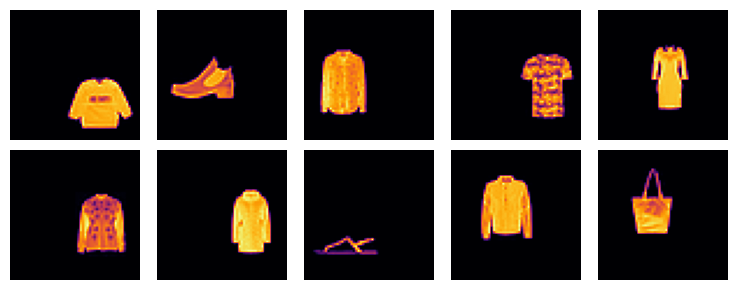

In [40]:
print(" >>> Dataset A")
plot_10_imagens(treino_loader_A)

print(" >>> Dataset B")
plot_10_imagens(treino_loader_B)
plot_10_imagens(treino_loader_B)

print(" >>> Dataset C")
plot_10_imagens(treino_loader_C)
plot_10_imagens(treino_loader_C)

## MLP - Definições das Arquiteturas:

Para os modelos de MLP, vamos usar 3 arquiteturas diferentes. 

#### MLP 1 - Modelo X

In [41]:
class MLP_Modelo_X(nn.Module):
    def __init__(self, tamanho_entrada, tamanho_saida):
        super(MLP_Modelo_X, self).__init__()
        self.camada_1 = nn.Linear(tamanho_entrada, 128)
        self.camada_2 = nn.Linear(128, 64)
        self.camada_saida = nn.Linear(64, tamanho_saida)
        self.func_ativacao = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        X = self.func_ativacao(self.camada_1(X))
        X = self.func_ativacao(self.camada_2(X))
        X = self.camada_saida(X)
        X = self.softmax(X)
        return X

#### MLP 2 - Modelo Y

In [42]:
class MLP_Modelo_Y(nn.Module):
    def __init__(self, tamanho_entrada, tamanho_saida):
        super(MLP_Modelo_Y, self).__init__()
        self.camada_1 = nn.Linear(tamanho_entrada, 256)
        self.camada_2 = nn.Linear(256, 128)
        self.camada_3 = nn.Linear(128, 64)
        self.camada_saida = nn.Linear(64, tamanho_saida)
        self.func_ativacao = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        X = self.func_ativacao(self.camada_1(X))
        X = self.func_ativacao(self.camada_2(X))
        X = self.func_ativacao(self.camada_3(X))
        X = self.camada_saida(X)
        X = self.softmax(X)
        return X

#### MLP 3 - Modelo Z

In [43]:
class MLP_Modelo_Z(nn.Module):
    def __init__(self, tamanho_entrada, tamanho_saida):
        super(MLP_Modelo_Z, self).__init__()
        self.camada_1 = nn.Linear(tamanho_entrada, 512)
        self.camada_2 = nn.Linear(512, 256)
        self.camada_3 = nn.Linear(256, 128)
        self.camada_4 = nn.Linear(128, 64)
        self.camada_saida = nn.Linear(64, tamanho_saida)
        self.func_ativacao = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        X = self.func_ativacao(self.camada_1(X))
        X = self.func_ativacao(self.camada_2(X))
        X = self.func_ativacao(self.camada_3(X))
        X = self.func_ativacao(self.camada_4(X))
        X = self.camada_saida(X)
        X = self.softmax(X)
        return X

## Treinamento:

### Funções de Plotagem:

In [44]:
def plot_side_by_side(lista_perdas, acuracias_treino, acuracias_teste):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 

    # Plot para lista_perdas
    ax1.plot(lista_perdas, label='Transformada')
    ax1.set_title('Perdas')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Perda')
    ax1.legend()

    # Plot para acuracias_treino e acuracias_teste
    ax2.plot(acuracias_treino, label='Treino', color='orange')
    ax2.plot(acuracias_teste, label='Teste', color='blue')
    ax2.set_title('Acurácias: Treino vs Teste')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Acurácia')
    ax2.legend()

    plt.tight_layout()  
    plt.show()

In [45]:
def plot_vetores_peso(vetores_peso, dimensao=28):
    aux = vetores_peso.view(10, dimensao, dimensao)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  
    for i in range(10):
        ax = axes[i // 5, i % 5]
        ax.imshow(aux[i].detach().numpy(), cmap='gray')
        ax.set_title(f'Imagem {i + 1}')
        ax.axis('off')  
    
    plt.tight_layout()
    plt.show()

### Acurácia & Teste:

In [46]:
def acuracia(saidas, rotulos):
    _, predicao = torch.max(saidas, 1)
    return (predicao == rotulos).sum().item() / len(predicao)

def teste(modelo, test_loader):
    modelo.eval()
    total_acertos = 0
    total_amostras = 0

    with torch.no_grad():
        for dados_teste, rotulos_teste in test_loader:
            dados_teste = dados_teste.to('cuda')
            rotulos_teste = rotulos_teste.to('cuda')

            saidas = modelo(dados_teste)
            total_acertos += (saidas.argmax(dim=1) == rotulos_teste).sum().item()
            total_amostras += rotulos_teste.size(0)
            del dados_teste, rotulos_teste, saidas
            torch.cuda.empty_cache()

    acc_total = total_acertos / total_amostras
    # print(f' >> Acurácia: {acc_total:.2f}')
    return acc_total

### Função de Treino:

In [47]:
def treino(modelo, otimizador, perda, dados, dados_teste, num_epocas = 10):
    lista_perdas = []
    acuracias_treino = []
    acuracias_teste = []

    modelo.train()

    for epoca in range(num_epocas):
        print(f'Época: {epoca + 1}/{num_epocas}')
        total_acertos = 0
        total_amostras = 0
        perdas_por_batch = []

        for dados_batch, rotulos_batch in dados:
            dados_batch = dados_batch.to('cuda')
            rotulos_batch = rotulos_batch.to('cuda')

            otimizador.zero_grad()
            saidas = modelo(dados_batch)

            total_acertos += (saidas.argmax(dim=1) == rotulos_batch).sum().item()
            # print(rotulos_batch.size(0))
            total_amostras += rotulos_batch.size(0)


            erro = perda(saidas, rotulos_batch)
            erro.backward()
            otimizador.step()
            perdas_por_batch.append(erro.item())

            del dados_batch, rotulos_batch, saidas, erro
            torch.cuda.empty_cache()
        lista_perdas.append(sum(perdas_por_batch) / len(perdas_por_batch))
        acuracias_treino.append(total_acertos / total_amostras)
        acuracias_teste.append(teste(modelo, dados_teste))
        print(f'Época {epoca + 1}: Acurácia Treino: {acuracias_treino[-1]:.2f}')
        print(f'Época {epoca + 1}: Acurácia Teste: {acuracias_teste[-1]:.2f}')


    return lista_perdas, acuracias_teste, acuracias_treino

### Instâncias de Modelos e Treinos:

#### Dataset A:

##### Modelo X:

In [48]:
modelo_x_a = MLP_Modelo_X(28 * 28, 10).to('cuda')
perda_x = nn.CrossEntropyLoss()
otimizador_x_a = torch.optim.Adam(modelo_x_a.parameters(), lr=0.001)

 >>> Treino Modelo X - Dataset A
Época: 1/15
Época 1: Acurácia Treino: 0.78
Época 1: Acurácia Teste: 0.83
Época: 2/15
Época 2: Acurácia Treino: 0.83
Época 2: Acurácia Teste: 0.85
Época: 3/15
Época 3: Acurácia Treino: 0.85
Época 3: Acurácia Teste: 0.85
Época: 4/15
Época 4: Acurácia Treino: 0.86
Época 4: Acurácia Teste: 0.86
Época: 5/15
Época 5: Acurácia Treino: 0.86
Época 5: Acurácia Teste: 0.86
Época: 6/15
Época 6: Acurácia Treino: 0.87
Época 6: Acurácia Teste: 0.86
Época: 7/15
Época 7: Acurácia Treino: 0.87
Época 7: Acurácia Teste: 0.86
Época: 8/15
Época 8: Acurácia Treino: 0.87
Época 8: Acurácia Teste: 0.87
Época: 9/15
Época 9: Acurácia Treino: 0.87
Época 9: Acurácia Teste: 0.87
Época: 10/15
Época 10: Acurácia Treino: 0.88
Época 10: Acurácia Teste: 0.87
Época: 11/15
Época 11: Acurácia Treino: 0.88
Época 11: Acurácia Teste: 0.86
Época: 12/15
Época 12: Acurácia Treino: 0.88
Época 12: Acurácia Teste: 0.88
Época: 13/15
Época 13: Acurácia Treino: 0.88
Época 13: Acurácia Teste: 0.88
Época:

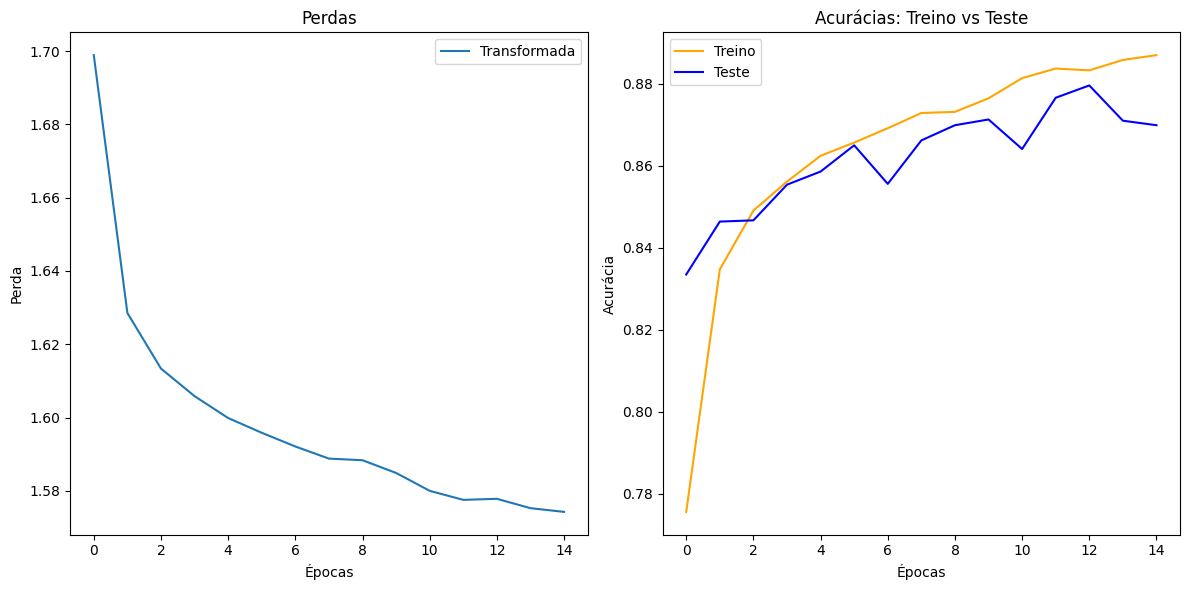

In [49]:
#### Dataset A
print(" >>> Treino Modelo X - Dataset A")
lista_perdas_x_A, acuracias_teste_x_A, acuracias_treino_x_A = treino(modelo_x_a, otimizador_x_a, perda_x, treino_loader_A, teste_loader_A, num_epocas=15)
plot_side_by_side(lista_perdas_x_A, acuracias_treino_x_A, acuracias_teste_x_A)

torch.Size([10, 784])


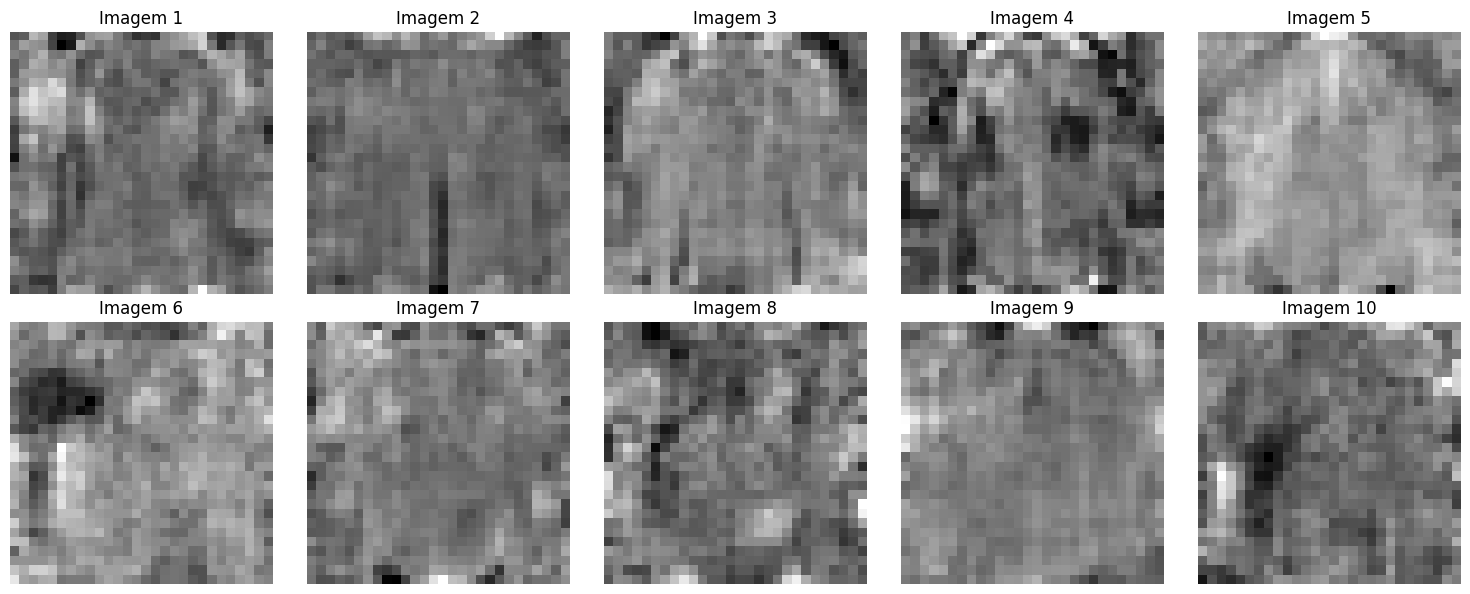

In [50]:
modelo_x_a.cpu()
vetores_peso = modelo_x_a.camada_saida.weight @ modelo_x_a.camada_2.weight 
vetores_peso = vetores_peso @ modelo_x_a.camada_1.weight
print(vetores_peso.shape)
plot_vetores_peso(vetores_peso)

In [51]:
del modelo_x_a, otimizador_x_a, perda_x
torch.cuda.empty_cache()

##### Modelo Y:

In [52]:
modelo_y_a = MLP_Modelo_Y(28 * 28, 10).to('cuda')
perda_y = nn.CrossEntropyLoss()
otimizador_y_a = torch.optim.Adam(modelo_y_a.parameters(), lr=0.001)

 >>> Treino Modelo Y - Dataset A
Época: 1/15
Época 1: Acurácia Treino: 0.76
Época 1: Acurácia Teste: 0.82
Época: 2/15
Época 2: Acurácia Treino: 0.82
Época 2: Acurácia Teste: 0.82
Época: 3/15
Época 3: Acurácia Treino: 0.84
Época 3: Acurácia Teste: 0.85
Época: 4/15
Época 4: Acurácia Treino: 0.85
Época 4: Acurácia Teste: 0.85
Época: 5/15
Época 5: Acurácia Treino: 0.85
Época 5: Acurácia Teste: 0.85
Época: 6/15
Época 6: Acurácia Treino: 0.86
Época 6: Acurácia Teste: 0.85
Época: 7/15
Época 7: Acurácia Treino: 0.86
Época 7: Acurácia Teste: 0.87
Época: 8/15
Época 8: Acurácia Treino: 0.86
Época 8: Acurácia Teste: 0.87
Época: 9/15
Época 9: Acurácia Treino: 0.87
Época 9: Acurácia Teste: 0.87
Época: 10/15
Época 10: Acurácia Treino: 0.87
Época 10: Acurácia Teste: 0.86
Época: 11/15
Época 11: Acurácia Treino: 0.87
Época 11: Acurácia Teste: 0.87
Época: 12/15
Época 12: Acurácia Treino: 0.87
Época 12: Acurácia Teste: 0.85
Época: 13/15
Época 13: Acurácia Treino: 0.87
Época 13: Acurácia Teste: 0.87
Época:

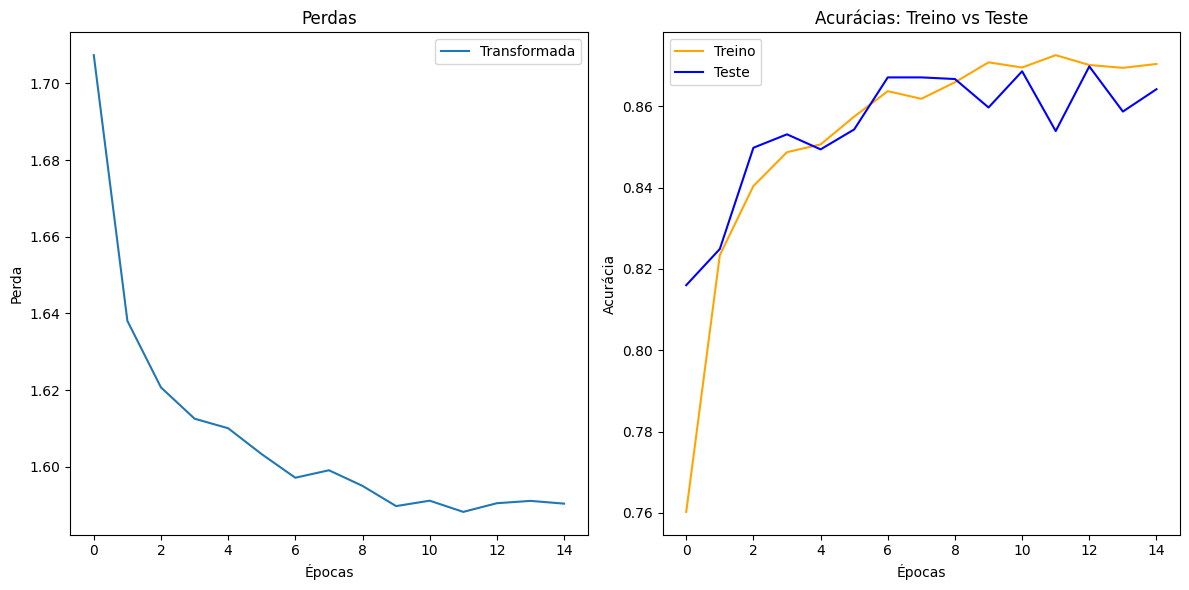

In [53]:
#### Dataset A
print(" >>> Treino Modelo Y - Dataset A")
lista_perdas_y_A, acuracias_teste_y_A, acuracias_treino_y_A = treino(modelo_y_a, otimizador_y_a, perda_y, treino_loader_A, teste_loader_A, num_epocas=15)
plot_side_by_side(lista_perdas_y_A, acuracias_treino_y_A, acuracias_teste_y_A)

torch.Size([10, 784])


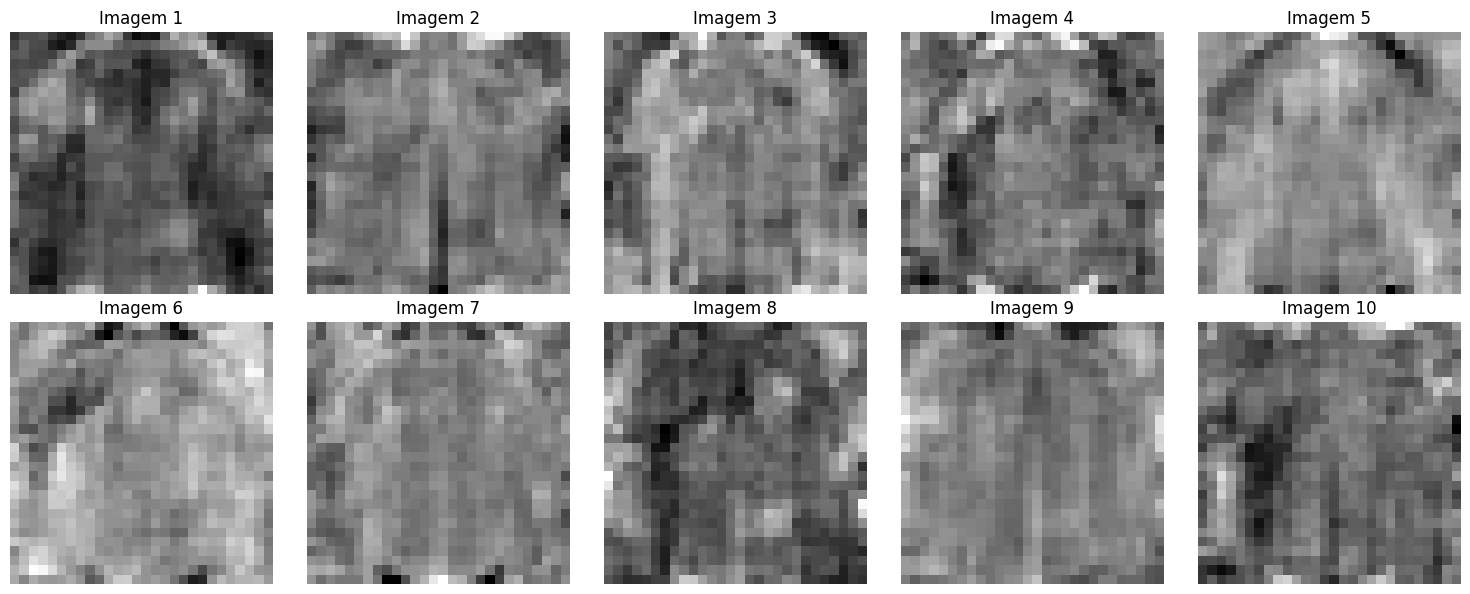

In [54]:
modelo_y_a.cpu()
vetores_peso = modelo_y_a.camada_saida.weight @ modelo_y_a.camada_3.weight
vetores_peso = vetores_peso @ modelo_y_a.camada_2.weight
vetores_peso = vetores_peso @ modelo_y_a.camada_1.weight
print(vetores_peso.shape)
plot_vetores_peso(vetores_peso)

In [55]:
del modelo_y_a, otimizador_y_a, perda_y
torch.cuda.empty_cache()

##### Modelo Z:

In [56]:
modelo_z_a = MLP_Modelo_Z(28 * 28, 10).to('cuda')
perda_z = nn.CrossEntropyLoss()
otimizador_z_a = torch.optim.Adam(modelo_z_a.parameters(), lr=0.001)

 >>> Treino Modelo Z - Dataset A
Época: 1/15
Época 1: Acurácia Treino: 0.71
Época 1: Acurácia Teste: 0.76
Época: 2/15
Época 2: Acurácia Treino: 0.78
Época 2: Acurácia Teste: 0.79
Época: 3/15
Época 3: Acurácia Treino: 0.81
Época 3: Acurácia Teste: 0.81
Época: 4/15
Época 4: Acurácia Treino: 0.82
Época 4: Acurácia Teste: 0.81
Época: 5/15
Época 5: Acurácia Treino: 0.83
Época 5: Acurácia Teste: 0.83
Época: 6/15
Época 6: Acurácia Treino: 0.83
Época 6: Acurácia Teste: 0.83
Época: 7/15
Época 7: Acurácia Treino: 0.83
Época 7: Acurácia Teste: 0.82
Época: 8/15
Época 8: Acurácia Treino: 0.83
Época 8: Acurácia Teste: 0.81
Época: 9/15
Época 9: Acurácia Treino: 0.84
Época 9: Acurácia Teste: 0.85
Época: 10/15
Época 10: Acurácia Treino: 0.83
Época 10: Acurácia Teste: 0.84
Época: 11/15
Época 11: Acurácia Treino: 0.84
Época 11: Acurácia Teste: 0.84
Época: 12/15
Época 12: Acurácia Treino: 0.83
Época 12: Acurácia Teste: 0.83
Época: 13/15
Época 13: Acurácia Treino: 0.83
Época 13: Acurácia Teste: 0.83
Época:

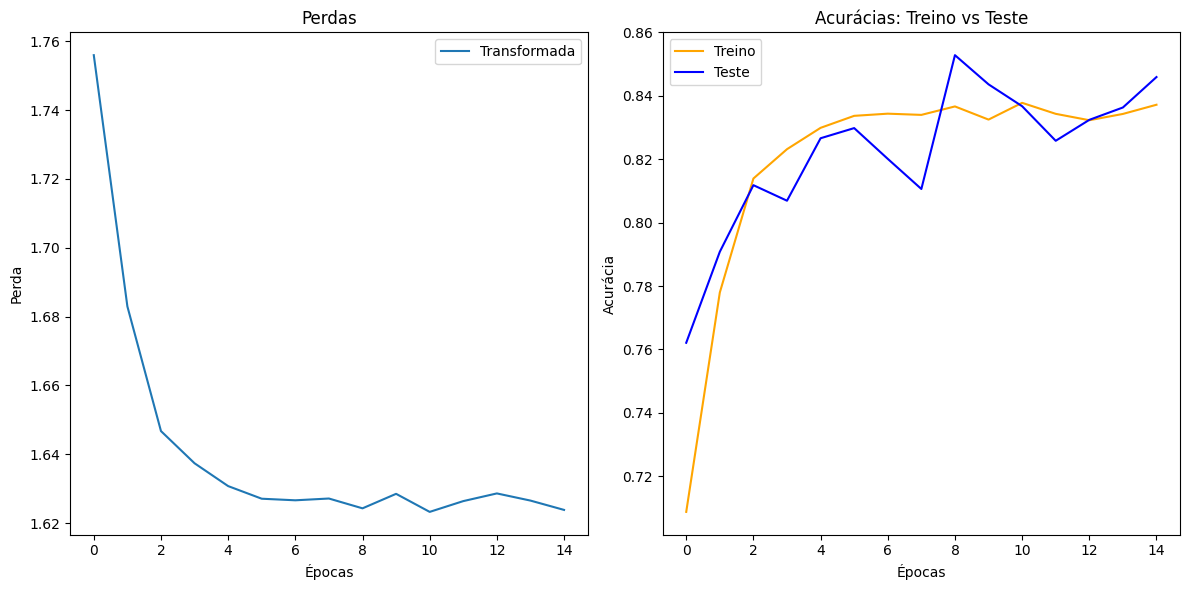

In [57]:
#### Dataset A
print(" >>> Treino Modelo Z - Dataset A")
lista_perdas_z_A, acuracias_teste_z_A, acuracias_treino_z_A = treino(modelo_z_a, otimizador_z_a, perda_z, treino_loader_A, teste_loader_A, num_epocas=15)
plot_side_by_side(lista_perdas_z_A, acuracias_treino_z_A, acuracias_teste_z_A)

torch.Size([10, 784])


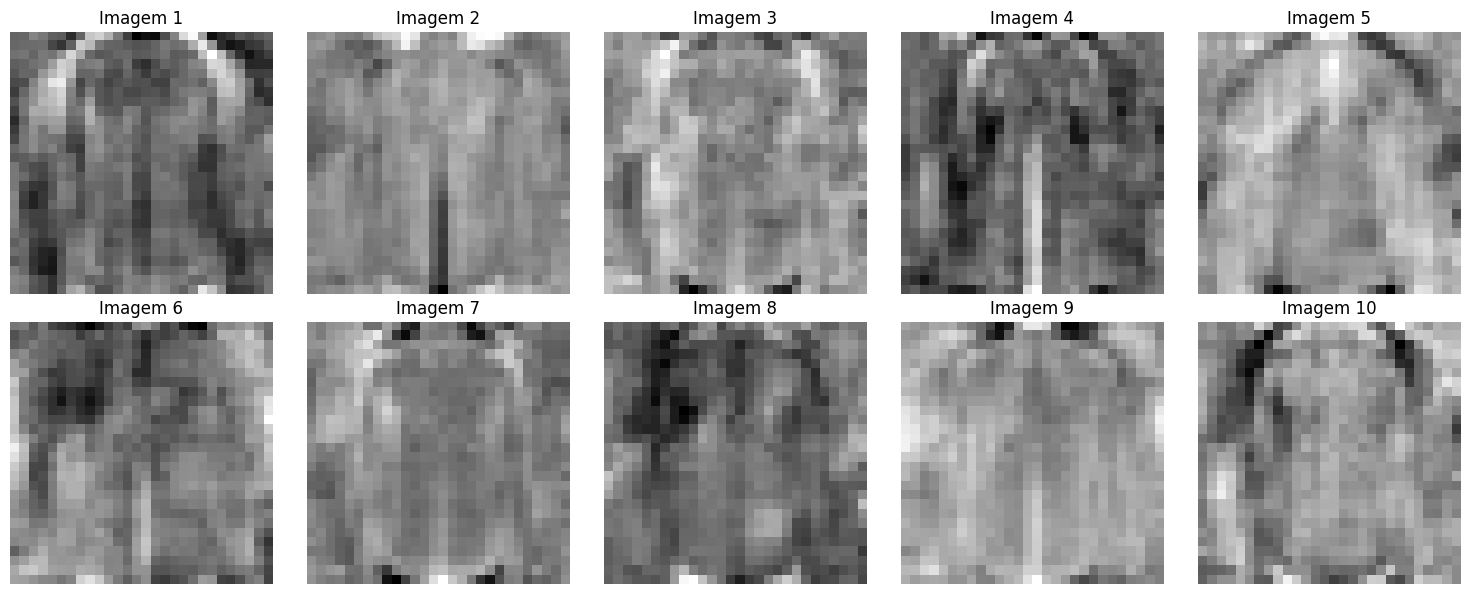

In [58]:
modelo_z_a.cpu()
vetores_peso = modelo_z_a.camada_saida.weight @ modelo_z_a.camada_4.weight
vetores_peso = vetores_peso @ modelo_z_a.camada_3.weight
vetores_peso = vetores_peso @ modelo_z_a.camada_2.weight
vetores_peso = vetores_peso @ modelo_z_a.camada_1.weight
print(vetores_peso.shape)
plot_vetores_peso(vetores_peso)

In [59]:
del modelo_z_a, otimizador_z_a, perda_z
torch.cuda.empty_cache()

#### Dataset B:

##### Modelo X:

In [78]:
modelo_x_b = MLP_Modelo_X(56 * 56, 10).to('cuda')
perda_x = nn.CrossEntropyLoss()
otimizador_x_b = torch.optim.Adam(modelo_x_b.parameters(), lr=0.001)

In [79]:
#### Dataset B
print(" >>> Treino Modelo X - Dataset B")
lista_perdas_x_B, acuracias_teste_x_B, acuracias_treino_x_B = treino(modelo_x_b, otimizador_x_b, perda_x, treino_loader_B, teste_loader_B, num_epocas=50)

 >>> Treino Modelo X - Dataset B
Época: 1/50
Época 1: Acurácia Treino: 0.52
Época 1: Acurácia Teste: 0.63
Época: 2/50
Época 2: Acurácia Treino: 0.66
Época 2: Acurácia Teste: 0.65
Época: 3/50
Época 3: Acurácia Treino: 0.68
Época 3: Acurácia Teste: 0.66
Época: 4/50
Época 4: Acurácia Treino: 0.70
Época 4: Acurácia Teste: 0.67
Época: 5/50
Época 5: Acurácia Treino: 0.71
Época 5: Acurácia Teste: 0.69
Época: 6/50
Época 6: Acurácia Treino: 0.72
Época 6: Acurácia Teste: 0.69
Época: 7/50
Época 7: Acurácia Treino: 0.72
Época 7: Acurácia Teste: 0.69
Época: 8/50
Época 8: Acurácia Treino: 0.73
Época 8: Acurácia Teste: 0.69
Época: 9/50
Época 9: Acurácia Treino: 0.74
Época 9: Acurácia Teste: 0.70
Época: 10/50
Época 10: Acurácia Treino: 0.74
Época 10: Acurácia Teste: 0.70
Época: 11/50
Época 11: Acurácia Treino: 0.75
Época 11: Acurácia Teste: 0.69
Época: 12/50
Época 12: Acurácia Treino: 0.75
Época 12: Acurácia Teste: 0.70
Época: 13/50
Época 13: Acurácia Treino: 0.76
Época 13: Acurácia Teste: 0.70
Época:

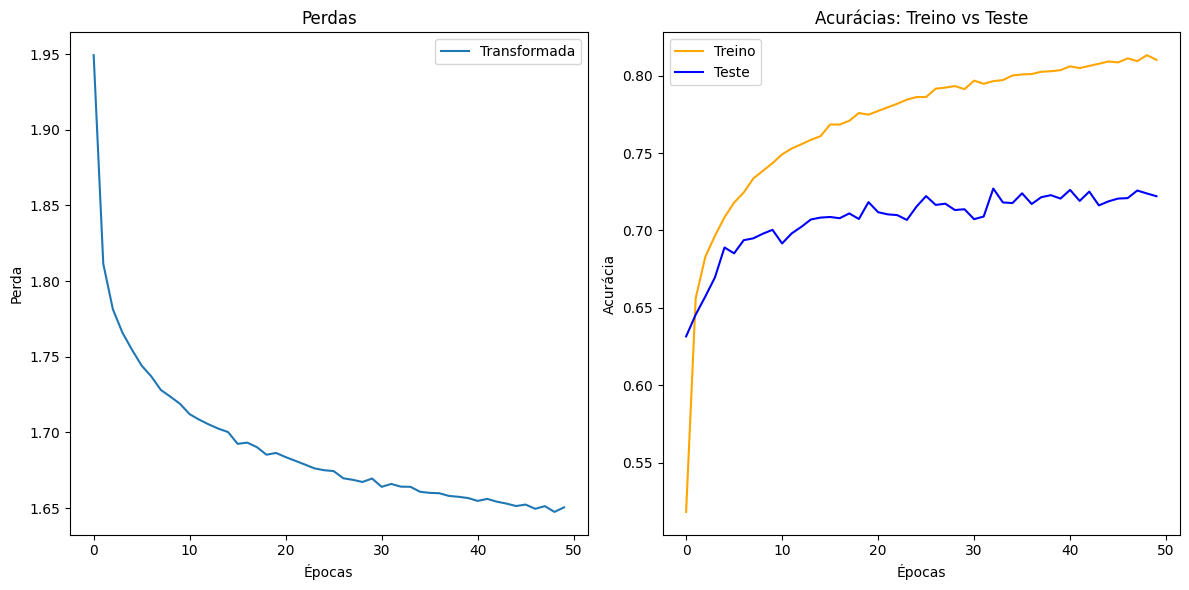

In [80]:
plot_side_by_side(lista_perdas_x_B, acuracias_treino_x_B, acuracias_teste_x_B)

torch.Size([10, 3136])


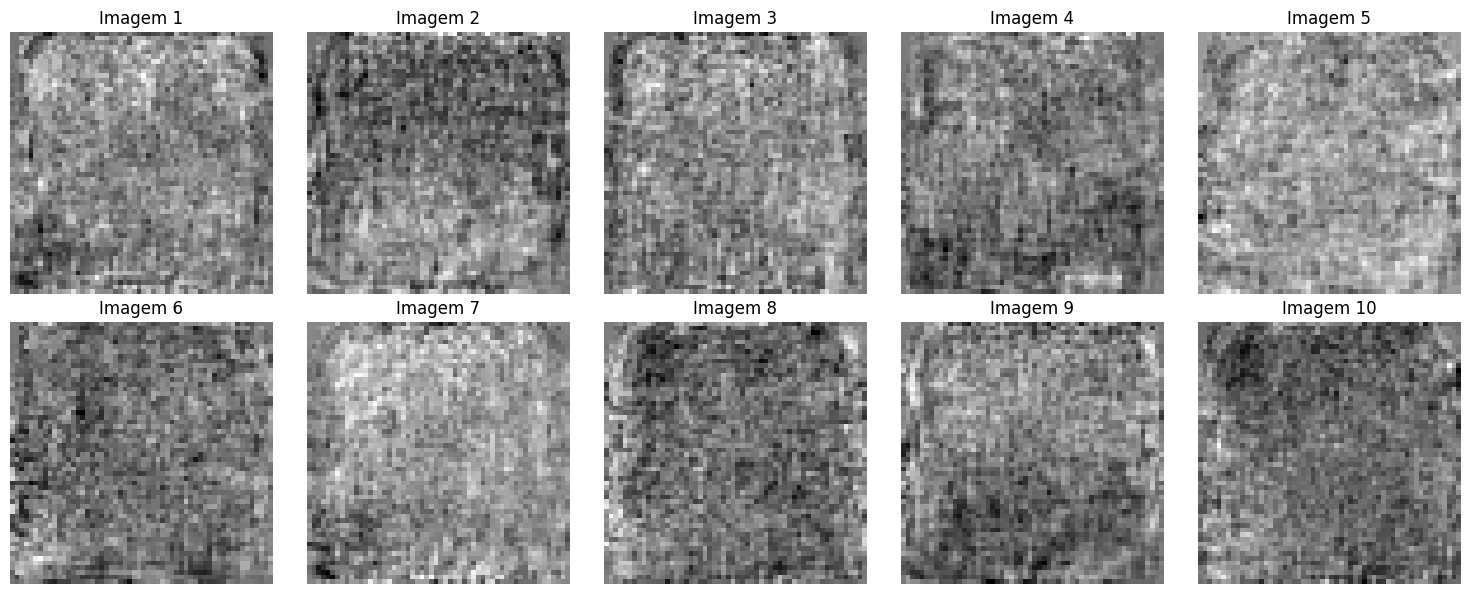

In [96]:
modelo_x_b.cpu()
vetores_peso = modelo_x_b.camada_saida.weight @ modelo_x_b.camada_2.weight
vetores_peso = vetores_peso @ modelo_x_b.camada_1.weight
print(vetores_peso.shape)
plot_vetores_peso(vetores_peso, dimensao=56)

##### Modelo Y:

In [92]:
modelo_y_b = MLP_Modelo_Y(56 * 56, 10).to('cuda')
perda_y = nn.CrossEntropyLoss()
otimizador_y_b = torch.optim.Adam(modelo_y_b.parameters(), lr=0.0001)

In [93]:
#### Dataset B
print(" >>> Treino Modelo Y - Dataset B")
lista_perdas_y_B, acuracias_teste_y_B, acuracias_treino_y_B = treino(modelo_y_b, otimizador_y_b, perda_y, treino_loader_B, teste_loader_B, num_epocas=50)

 >>> Treino Modelo Y - Dataset B
Época: 1/50
Época 1: Acurácia Treino: 0.41
Época 1: Acurácia Teste: 0.57
Época: 2/50
Época 2: Acurácia Treino: 0.58
Época 2: Acurácia Teste: 0.59
Época: 3/50
Época 3: Acurácia Treino: 0.61
Época 3: Acurácia Teste: 0.61
Época: 4/50
Época 4: Acurácia Treino: 0.63
Época 4: Acurácia Teste: 0.63
Época: 5/50
Época 5: Acurácia Treino: 0.66
Época 5: Acurácia Teste: 0.64
Época: 6/50
Época 6: Acurácia Treino: 0.68
Época 6: Acurácia Teste: 0.65
Época: 7/50
Época 7: Acurácia Treino: 0.69
Época 7: Acurácia Teste: 0.65
Época: 8/50
Época 8: Acurácia Treino: 0.69
Época 8: Acurácia Teste: 0.66
Época: 9/50
Época 9: Acurácia Treino: 0.70
Época 9: Acurácia Teste: 0.66
Época: 10/50
Época 10: Acurácia Treino: 0.71
Época 10: Acurácia Teste: 0.66
Época: 11/50
Época 11: Acurácia Treino: 0.71
Época 11: Acurácia Teste: 0.67
Época: 12/50
Época 12: Acurácia Treino: 0.72
Época 12: Acurácia Teste: 0.67
Época: 13/50
Época 13: Acurácia Treino: 0.72
Época 13: Acurácia Teste: 0.67
Época:

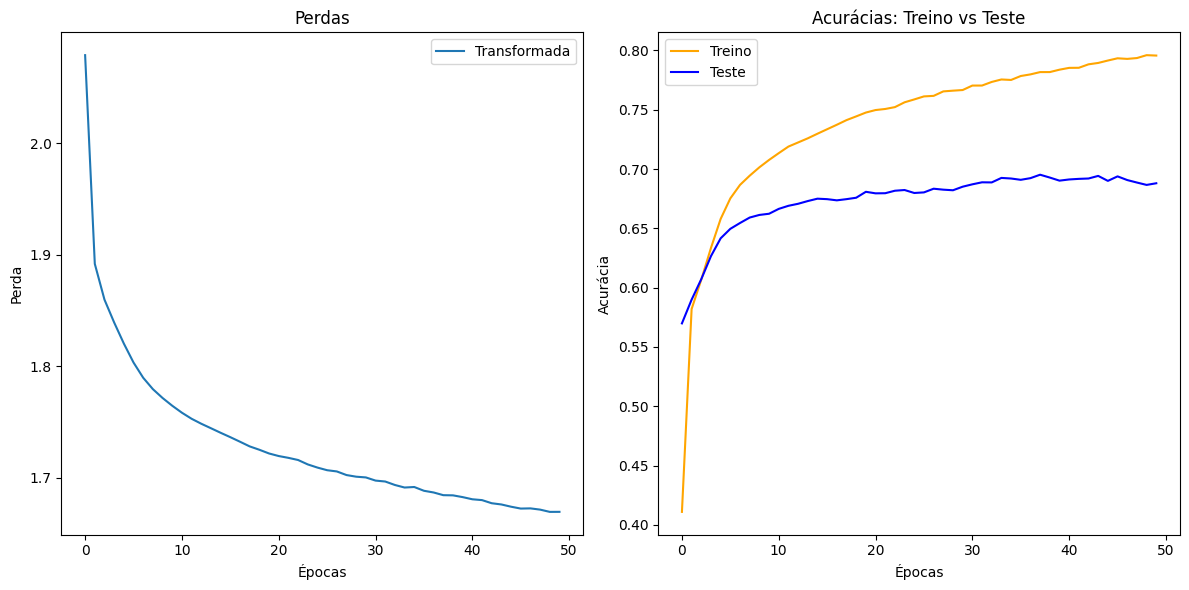

In [94]:
plot_side_by_side(lista_perdas_y_B, acuracias_treino_y_B, acuracias_teste_y_B)

torch.Size([10, 3136])


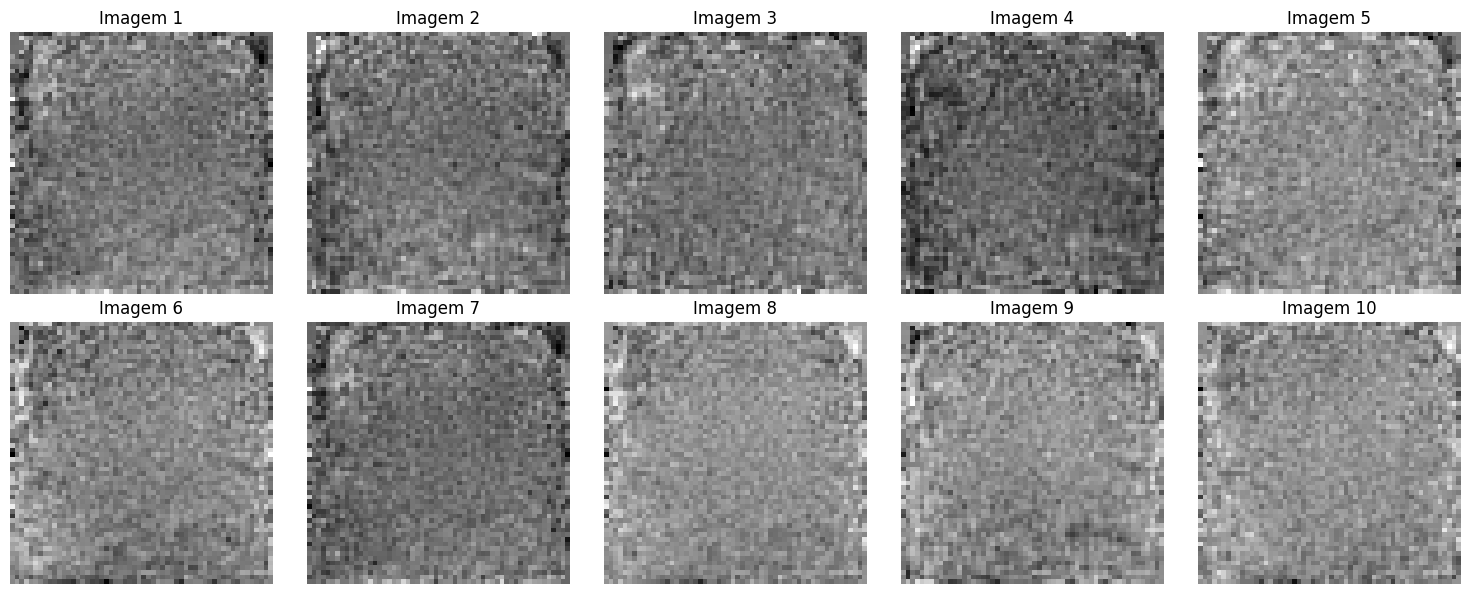

In [95]:
modelo_y_b.cpu()
vetores_peso = modelo_y_b.camada_saida.weight @ modelo_y_b.camada_3.weight
vetores_peso = vetores_peso @ modelo_y_b.camada_2.weight
vetores_peso = vetores_peso @ modelo_y_b.camada_1.weight
print(vetores_peso.shape)
plot_vetores_peso(vetores_peso, dimensao=56)

##### Modelo Z:

In [90]:
modelo_z_b = MLP_Modelo_Z(56 * 56, 10).to('cuda')
perda_z = nn.CrossEntropyLoss()
otimizador_z_b = torch.optim.Adam(modelo_z_b.parameters(), lr=0.0001)

 >>> Treino Modelo Z - Dataset B
Época: 1/50
Época 1: Acurácia Treino: 0.37
Época 1: Acurácia Teste: 0.49
Época: 2/50
Época 2: Acurácia Treino: 0.52
Época 2: Acurácia Teste: 0.54
Época: 3/50
Época 3: Acurácia Treino: 0.55
Época 3: Acurácia Teste: 0.56
Época: 4/50
Época 4: Acurácia Treino: 0.58
Época 4: Acurácia Teste: 0.57
Época: 5/50
Época 5: Acurácia Treino: 0.59
Época 5: Acurácia Teste: 0.56
Época: 6/50
Época 6: Acurácia Treino: 0.60
Época 6: Acurácia Teste: 0.57
Época: 7/50
Época 7: Acurácia Treino: 0.61
Época 7: Acurácia Teste: 0.58
Época: 8/50
Época 8: Acurácia Treino: 0.61
Época 8: Acurácia Teste: 0.58
Época: 9/50
Época 9: Acurácia Treino: 0.62
Época 9: Acurácia Teste: 0.58
Época: 10/50
Época 10: Acurácia Treino: 0.62
Época 10: Acurácia Teste: 0.58
Época: 11/50
Época 11: Acurácia Treino: 0.63
Época 11: Acurácia Teste: 0.58
Época: 12/50
Época 12: Acurácia Treino: 0.63
Época 12: Acurácia Teste: 0.59
Época: 13/50
Época 13: Acurácia Treino: 0.64
Época 13: Acurácia Teste: 0.59
Época:

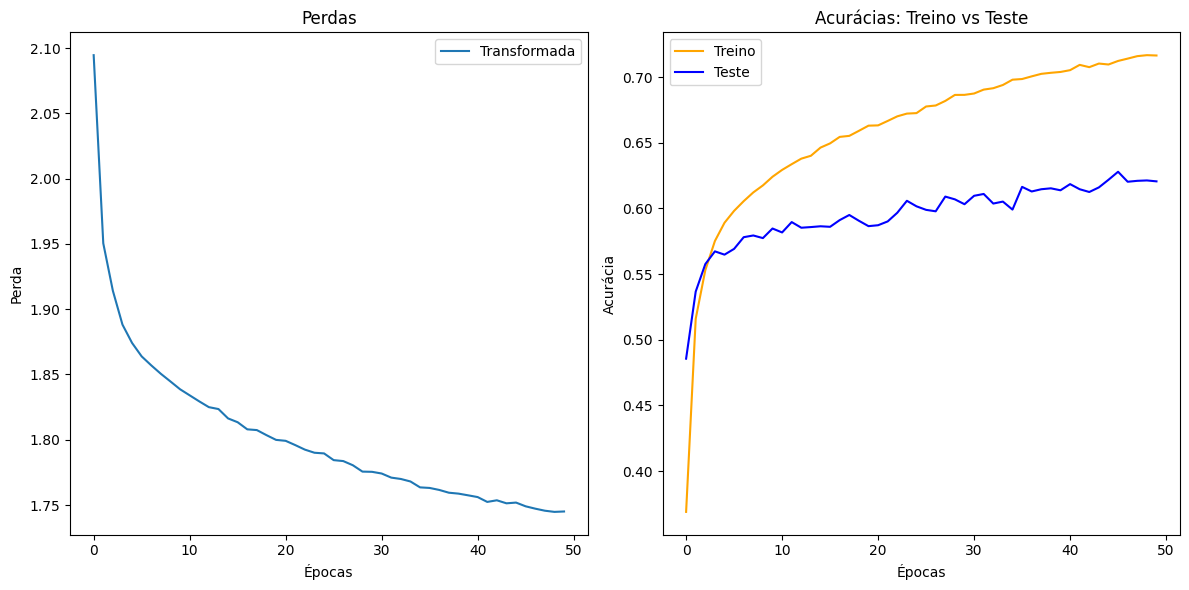

In [91]:
#### Dataset B
print(" >>> Treino Modelo Z - Dataset B")
lista_perdas_z_B, acuracias_teste_z_B, acuracias_treino_z_B = treino(modelo_z_b, otimizador_z_b, perda_z, treino_loader_B, teste_loader_B, num_epocas=50)
plot_side_by_side(lista_perdas_z_B, acuracias_treino_z_B, acuracias_teste_z_B)

torch.Size([10, 3136])


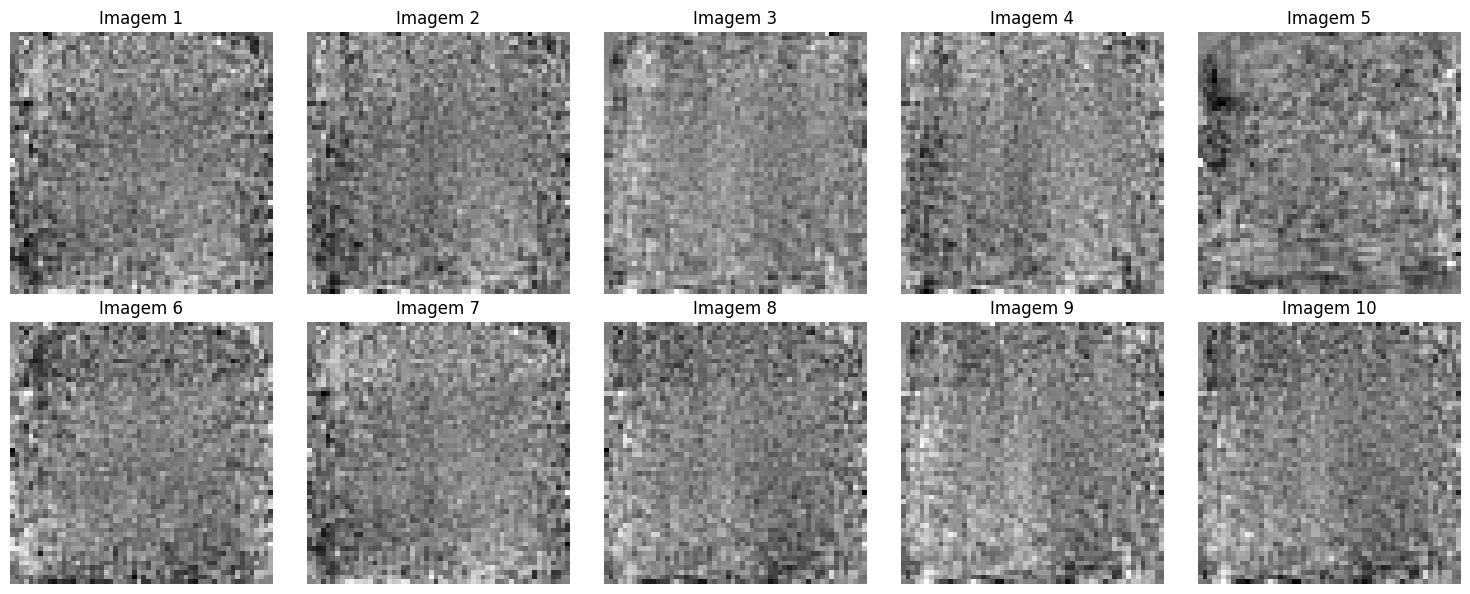

In [97]:
modelo_z_b.cpu()
vetores_peso = modelo_z_b.camada_saida.weight @ modelo_z_b.camada_4.weight
vetores_peso = vetores_peso @ modelo_z_b.camada_3.weight
vetores_peso = vetores_peso @ modelo_z_b.camada_2.weight
vetores_peso = vetores_peso @ modelo_z_b.camada_1.weight
print(vetores_peso.shape)
plot_vetores_peso(vetores_peso, dimensao=56)

### Dataset C:

#### Modelo X:

In [100]:
modelo_x_c = MLP_Modelo_X(56 * 56, 10).to('cuda')
perda_x = nn.CrossEntropyLoss()
otimizador_x_c = torch.optim.Adam(modelo_x_c.parameters(), lr=0.001)

 >>> Treino Modelo X - Dataset C
Época: 1/80
Época 1: Acurácia Treino: 0.49
Época 1: Acurácia Teste: 0.61
Época: 2/80
Época 2: Acurácia Treino: 0.63
Época 2: Acurácia Teste: 0.65
Época: 3/80
Época 3: Acurácia Treino: 0.66
Época 3: Acurácia Teste: 0.67
Época: 4/80
Época 4: Acurácia Treino: 0.67
Época 4: Acurácia Teste: 0.67
Época: 5/80
Época 5: Acurácia Treino: 0.68
Época 5: Acurácia Teste: 0.68
Época: 6/80
Época 6: Acurácia Treino: 0.68
Época 6: Acurácia Teste: 0.69
Época: 7/80
Época 7: Acurácia Treino: 0.69
Época 7: Acurácia Teste: 0.68
Época: 8/80
Época 8: Acurácia Treino: 0.69
Época 8: Acurácia Teste: 0.69
Época: 9/80
Época 9: Acurácia Treino: 0.69
Época 9: Acurácia Teste: 0.69
Época: 10/80
Época 10: Acurácia Treino: 0.70
Época 10: Acurácia Teste: 0.69
Época: 11/80
Época 11: Acurácia Treino: 0.70
Época 11: Acurácia Teste: 0.70
Época: 12/80
Época 12: Acurácia Treino: 0.70
Época 12: Acurácia Teste: 0.70
Época: 13/80
Época 13: Acurácia Treino: 0.70
Época 13: Acurácia Teste: 0.70
Época:

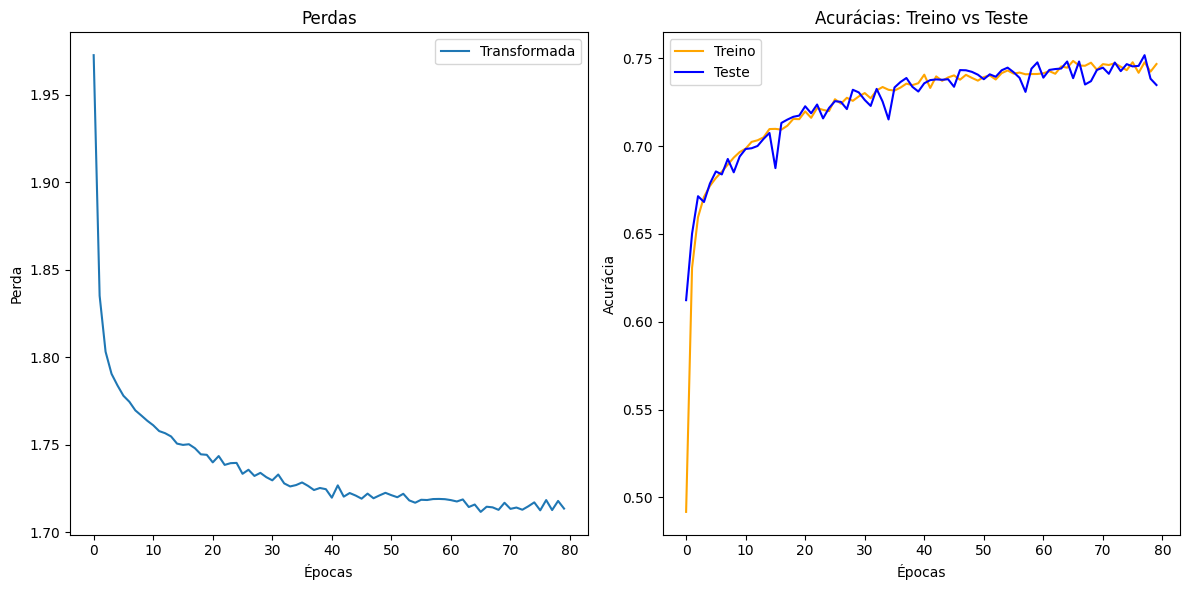

In [101]:
#### Dataset C
print(" >>> Treino Modelo X - Dataset C")
lista_perdas_x_C, acuracias_teste_x_C, acuracias_treino_x_C = treino(modelo_x_c, otimizador_x_c, perda_x, treino_loader_C, teste_loader_C, num_epocas=80)
plot_side_by_side(lista_perdas_x_C, acuracias_treino_x_C, acuracias_teste_x_C)

torch.Size([10, 3136])


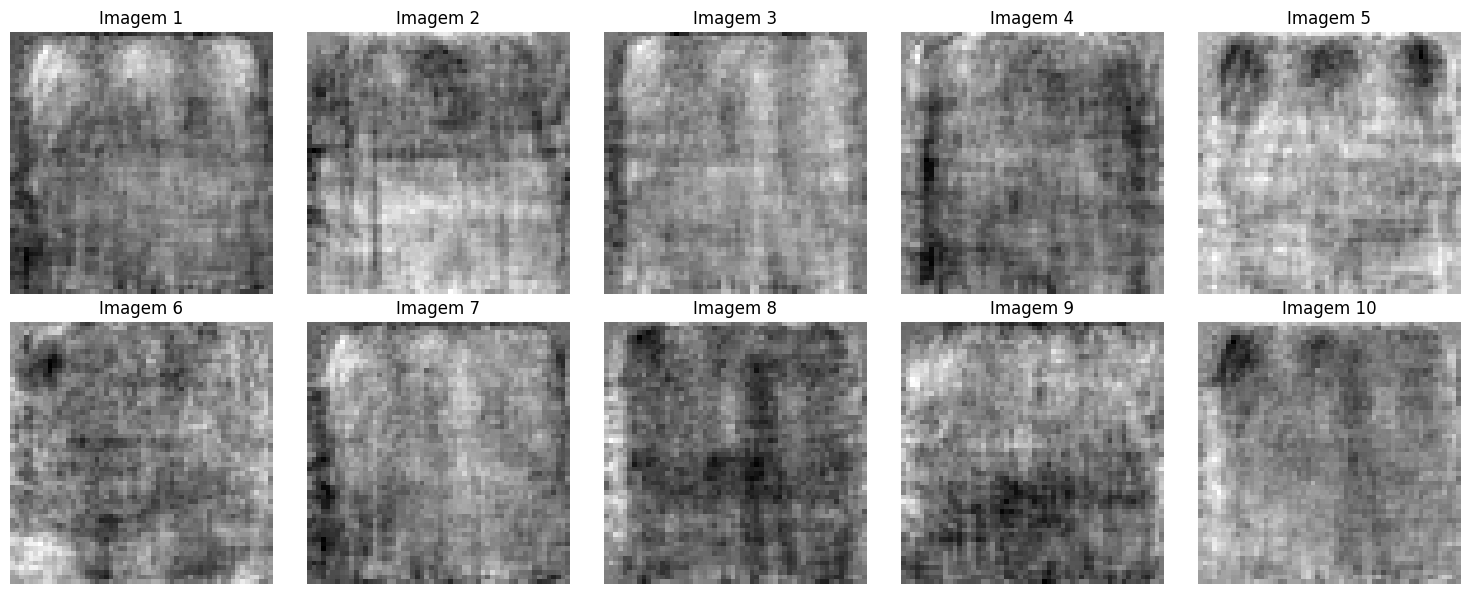

In [102]:
modelo_x_c.cpu()
vetores_peso = modelo_x_c.camada_saida.weight @ modelo_x_c.camada_2.weight
vetores_peso = vetores_peso @ modelo_x_c.camada_1.weight
print(vetores_peso.shape)
plot_vetores_peso(vetores_peso, dimensao=56)

##### Modelo Y:

In [109]:
modelo_y_c = MLP_Modelo_Y(56 * 56, 10).to('cuda')
perda_y = nn.CrossEntropyLoss()
otimizador_y_c = torch.optim.Adam(modelo_y_c.parameters(), lr=0.001)

 >>> Treino Modelo Y - Dataset C
Época: 1/80
Época 1: Acurácia Treino: 0.48
Época 1: Acurácia Teste: 0.58
Época: 2/80
Época 2: Acurácia Treino: 0.61
Época 2: Acurácia Teste: 0.63
Época: 3/80
Época 3: Acurácia Treino: 0.63
Época 3: Acurácia Teste: 0.64
Época: 4/80
Época 4: Acurácia Treino: 0.64
Época 4: Acurácia Teste: 0.64
Época: 5/80
Época 5: Acurácia Treino: 0.64
Época 5: Acurácia Teste: 0.65
Época: 6/80
Época 6: Acurácia Treino: 0.65
Época 6: Acurácia Teste: 0.64
Época: 7/80
Época 7: Acurácia Treino: 0.65
Época 7: Acurácia Teste: 0.65
Época: 8/80
Época 8: Acurácia Treino: 0.66
Época 8: Acurácia Teste: 0.67
Época: 9/80
Época 9: Acurácia Treino: 0.66
Época 9: Acurácia Teste: 0.66
Época: 10/80
Época 10: Acurácia Treino: 0.66
Época 10: Acurácia Teste: 0.67
Época: 11/80
Época 11: Acurácia Treino: 0.67
Época 11: Acurácia Teste: 0.66
Época: 12/80
Época 12: Acurácia Treino: 0.67
Época 12: Acurácia Teste: 0.66
Época: 13/80
Época 13: Acurácia Treino: 0.67
Época 13: Acurácia Teste: 0.67
Época:

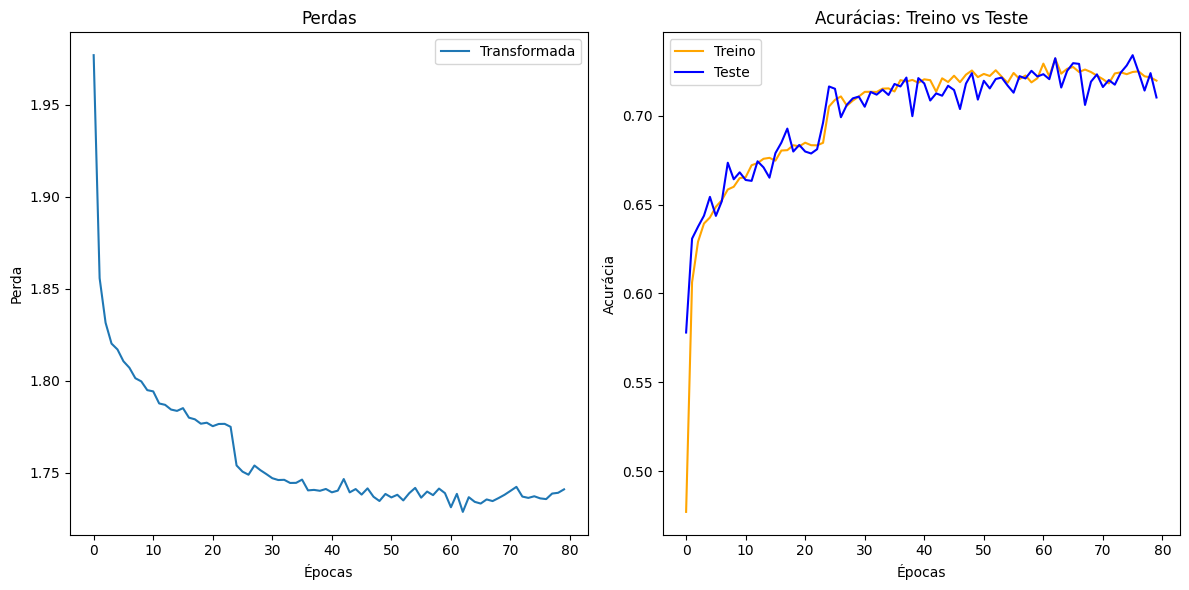

In [110]:
#### Dataset C
print(" >>> Treino Modelo Y - Dataset C")
lista_perdas_y_C, acuracias_teste_y_C, acuracias_treino_y_C = treino(modelo_y_c, otimizador_y_c, perda_y, treino_loader_C, teste_loader_C, num_epocas=80)
plot_side_by_side(lista_perdas_y_C, acuracias_treino_y_C, acuracias_teste_y_C)

torch.Size([10, 3136])


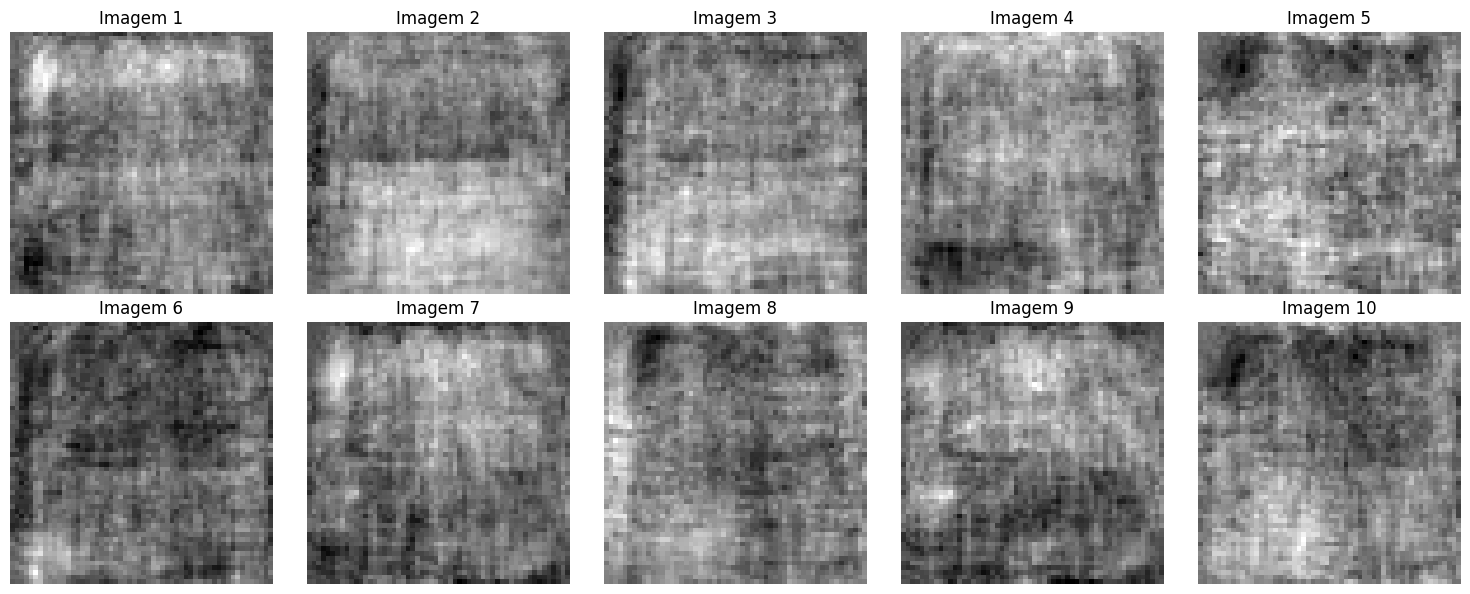

In [112]:
modelo_y_c.cpu()
vetores_peso = modelo_y_c.camada_saida.weight @ modelo_y_c.camada_3.weight
vetores_peso = vetores_peso @ modelo_y_c.camada_2.weight
vetores_peso = vetores_peso @ modelo_y_c.camada_1.weight
print(vetores_peso.shape)
plot_vetores_peso(vetores_peso, dimensao=56)

#### Modelo Z:

In [115]:
modelo_z_c = MLP_Modelo_Z(56 * 56, 10).to('cuda')
perda_z = nn.CrossEntropyLoss()
otimizador_z_c = torch.optim.Adam(modelo_z_c.parameters(), lr=0.001)

 >>> Treino Modelo Z - Dataset C
Época: 1/50
Época 1: Acurácia Treino: 0.41
Época 1: Acurácia Teste: 0.44
Época: 2/50
Época 2: Acurácia Treino: 0.51
Época 2: Acurácia Teste: 0.53
Época: 3/50
Época 3: Acurácia Treino: 0.52
Época 3: Acurácia Teste: 0.54
Época: 4/50
Época 4: Acurácia Treino: 0.54
Época 4: Acurácia Teste: 0.54
Época: 5/50
Época 5: Acurácia Treino: 0.55
Época 5: Acurácia Teste: 0.55
Época: 6/50
Época 6: Acurácia Treino: 0.55
Época 6: Acurácia Teste: 0.57
Época: 7/50
Época 7: Acurácia Treino: 0.56
Época 7: Acurácia Teste: 0.57
Época: 8/50
Época 8: Acurácia Treino: 0.57
Época 8: Acurácia Teste: 0.64
Época: 9/50
Época 9: Acurácia Treino: 0.65
Época 9: Acurácia Teste: 0.66
Época: 10/50
Época 10: Acurácia Treino: 0.65
Época 10: Acurácia Teste: 0.65
Época: 11/50
Época 11: Acurácia Treino: 0.66
Época 11: Acurácia Teste: 0.67
Época: 12/50
Época 12: Acurácia Treino: 0.67
Época 12: Acurácia Teste: 0.66
Época: 13/50
Época 13: Acurácia Treino: 0.66
Época 13: Acurácia Teste: 0.66
Época:

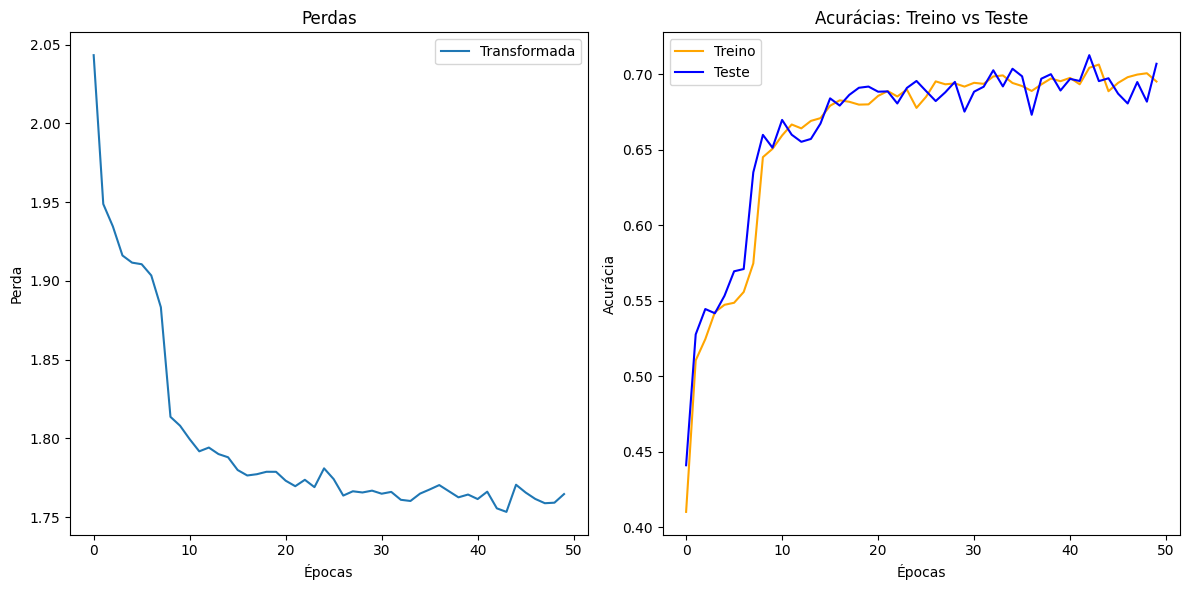

In [116]:
#### Dataset C
print(" >>> Treino Modelo Z - Dataset C")
lista_perdas_z_C, acuracias_teste_z_C, acuracias_treino_z_C = treino(modelo_z_c, otimizador_z_c, perda_z, treino_loader_C, teste_loader_C, num_epocas=50)
plot_side_by_side(lista_perdas_z_C, acuracias_treino_z_C, acuracias_teste_z_C)

torch.Size([10, 3136])


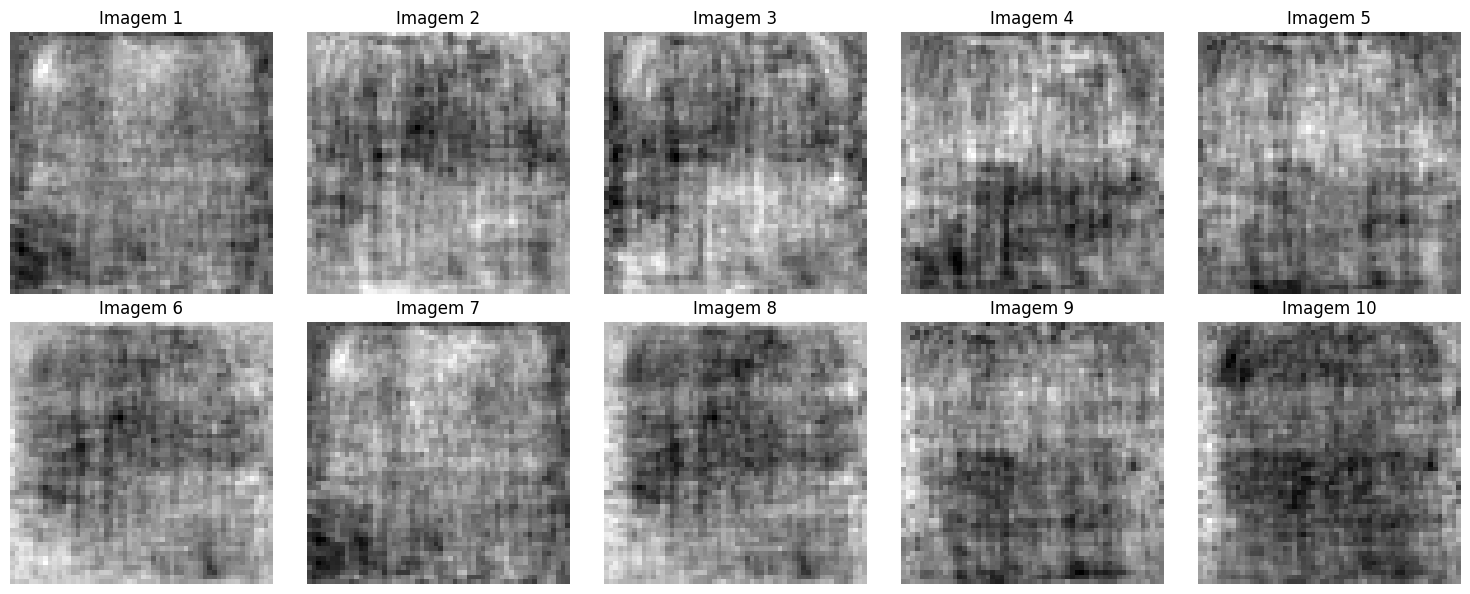

In [118]:
modelo_z_c.cpu()
vetores_peso = modelo_z_c.camada_saida.weight @ modelo_z_c.camada_4.weight
vetores_peso = vetores_peso @ modelo_z_c.camada_3.weight
vetores_peso = vetores_peso @ modelo_z_c.camada_2.weight
vetores_peso = vetores_peso @ modelo_z_c.camada_1.weight
print(vetores_peso.shape)
plot_vetores_peso(vetores_peso, dimensao=56)